# Five qubits error correcting code

Step by step implementation of the quantum circuit for the correction of both bit and phase flip erros, using the five-qubits encoding

## Importing needed modules

In [26]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info.states import Statevector
from math import sqrt

## Three qubit encoding

Because of the no cloning theorem we cannot copy a qubit to add redundancy like we would do in classical computing. What we can do instead is implementing the following encoding:<br><br>
<center>
$|0\rangle \rightarrow \frac{1}{4}[|00000\rangle + |00011\rangle + |00101\rangle + |00110\rangle + |01001\rangle + |01010\rangle + |01100>\rangle + |01111\rangle + |10001\rangle + |10010\rangle + |10111\rangle + |11011\rangle+ |11110\rangle + |00000\rangle + |00000\rangle + |11110\rangle]$
<br>
$|1\rangle \rightarrow \frac{1}{4}[|00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle+ |00000\rangle + |00000\rangle + |00000\rangle + |00000\rangle]$
</center>


## Inizializing the circuit

To implement the ciurcuit we need:
- 5 qubits for the encoding, where $|\psi\rangle$ is initially stored in the first
- 4 ancillary qubits that will be used to store the information of which error occurred and in which qubit
- A classical register of 4 bits to store the result of the measurement on the ancillary qubits

We'll use as initial state: $|\psi\rangle = \sqrt{\frac{3}{4}}|0\rangle + \sqrt{\frac{1}{4}}|1\rangle$

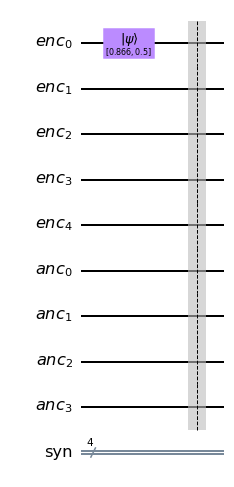

In [27]:
q_enc = QuantumRegister(5, "enc")
q_anc = QuantumRegister(4, "anc")
c_syn = ClassicalRegister(4, "syn")

alpha_in = sqrt(3/4)
beta_in = sqrt(1/4)
init_state = [alpha_in, beta_in]

qc = QuantumCircuit(q_enc, q_anc, c_syn)
qc.initialize(init_state, [q_enc[0]])
qc.barrier()
qc.draw(output="mpl")

## Implementing the encoding

The following cirucits produces the required encoding.

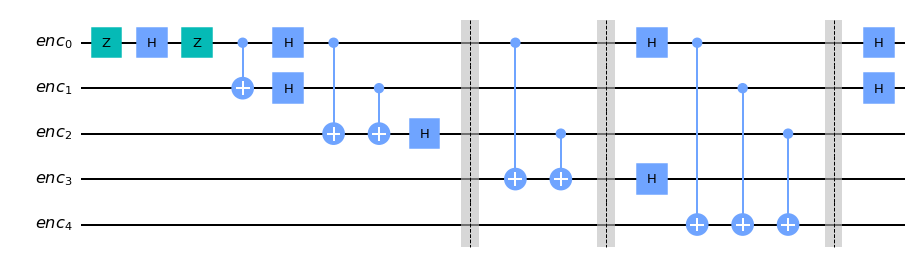

In [28]:
q_enc_t = QuantumRegister(5, "enc")
qc_encoding = QuantumCircuit(q_enc_t)

qc_encoding.z(q_enc_t[0])
qc_encoding.h(q_enc_t[0])
qc_encoding.z(q_enc_t[0])

qc_encoding.cx(q_enc_t[0], q_enc_t[1])

qc_encoding.h(q_enc_t[0])
qc_encoding.h(q_enc_t[1])

qc_encoding.cx(q_enc_t[0], q_enc_t[2])
qc_encoding.cx(q_enc_t[1], q_enc_t[2])

qc_encoding.h(q_enc_t[2])
qc_encoding.barrier()

qc_encoding.cx(q_enc_t[0], q_enc_t[3])
qc_encoding.cx(q_enc_t[2], q_enc_t[3])

qc_encoding.barrier()

qc_encoding.h(q_enc_t[0])
qc_encoding.h(q_enc_t[3])

qc_encoding.cx(q_enc_t[0], q_enc_t[4])
qc_encoding.cx(q_enc_t[1], q_enc_t[4])
qc_encoding.cx(q_enc_t[2], q_enc_t[4])

qc_encoding.barrier()

qc_encoding.h(q_enc_t[0])
qc_encoding.h(q_enc_t[1])

qc_encoding.draw(output="mpl")

## Adding the circuit for the encoding in the main circuit

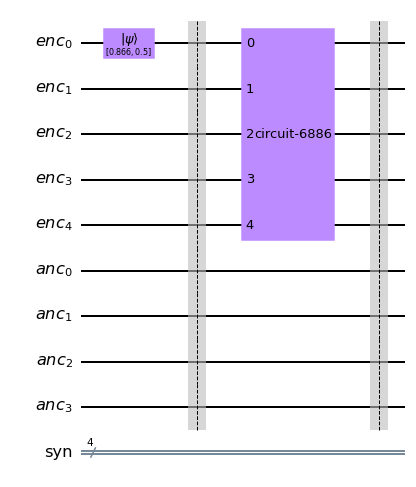

In [29]:
qc.append(qc_encoding, [q_enc[0], q_enc[1], q_enc[2], q_enc[3], q_enc[4]])
qc.barrier()
qc.draw("mpl")

## Defining the error cicuit

We simulate a bit-flip and phase-flip error by applying a $Y$ gate to the second qubit

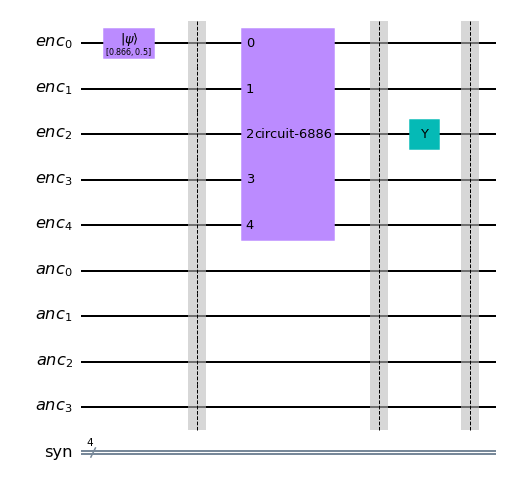

In [30]:
qc.y(q_enc[2])

qc.barrier()

qc.draw(output="mpl")

## Implementing the error detecting-correcting circuit

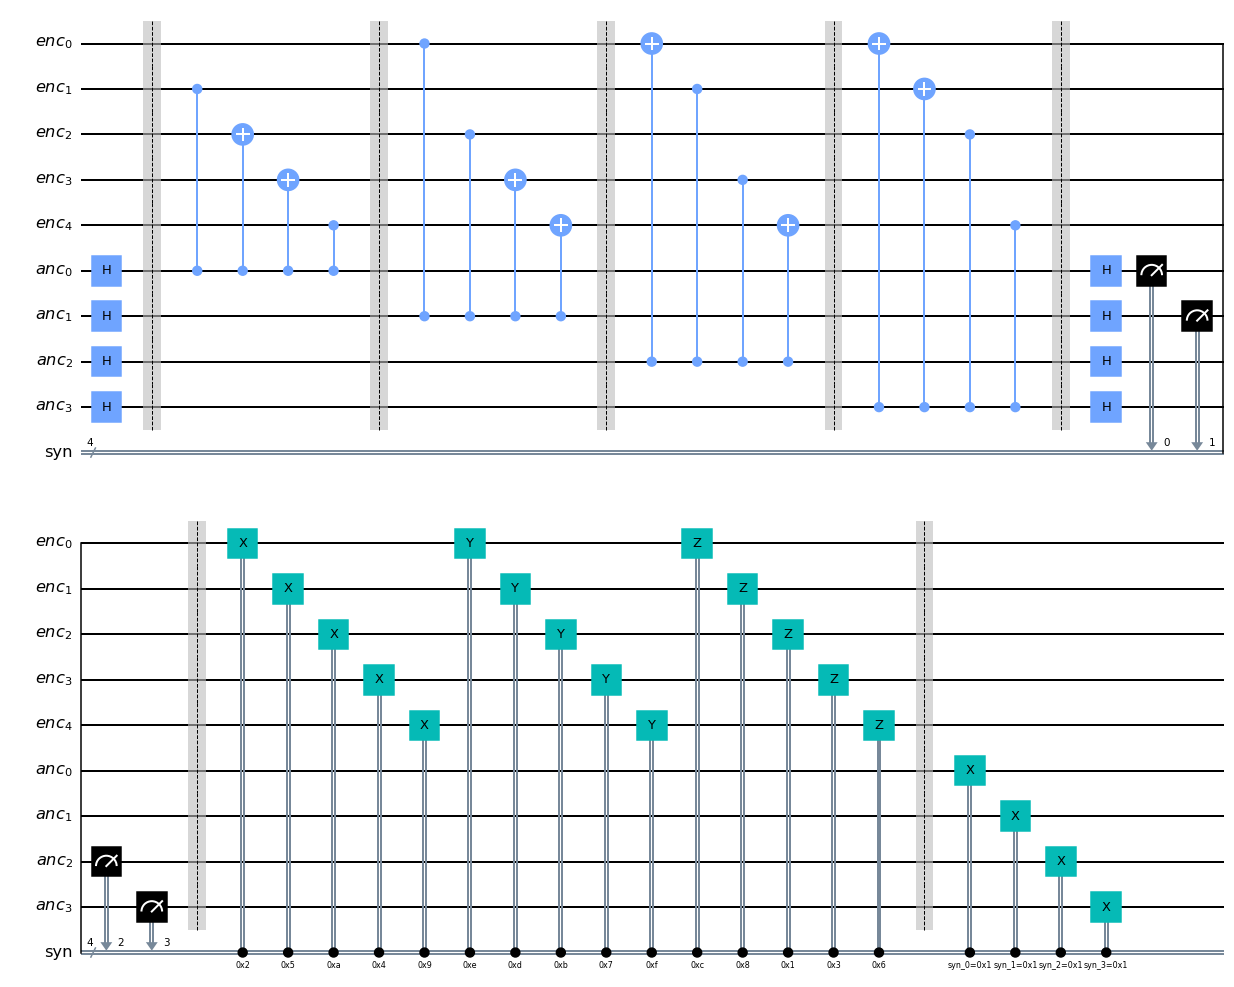

In [31]:
q_enc_t = QuantumRegister(5, "enc")
q_anc_t = QuantumRegister(4, "anc")
c_syn_t = ClassicalRegister(4, "syn")

qc_correct = QuantumCircuit(q_enc_t, q_anc_t, c_syn_t)
qc_correct.h(q_anc_t[0])
qc_correct.h(q_anc_t[1])
qc_correct.h(q_anc_t[2])
qc_correct.h(q_anc_t[3])
qc_correct.barrier()

qc_correct.cz(q_anc_t[0], q_enc_t[1])
qc_correct.cx(q_anc_t[0], q_enc_t[2])
qc_correct.cx(q_anc_t[0], q_enc_t[3])
qc_correct.cz(q_anc_t[0], q_enc_t[4])
qc_correct.barrier()


qc_correct.cz(q_anc_t[1], q_enc_t[0])
qc_correct.cz(q_anc_t[1], q_enc_t[2])
qc_correct.cx(q_anc_t[1], q_enc_t[3])
qc_correct.cx(q_anc_t[1], q_enc_t[4])
qc_correct.barrier()


qc_correct.cx(q_anc_t[2], q_enc_t[0])
qc_correct.cz(q_anc_t[2], q_enc_t[1])
qc_correct.cz(q_anc_t[2], q_enc_t[3])
qc_correct.cx(q_anc_t[2], q_enc_t[4])
qc_correct.barrier()


qc_correct.cx(q_anc_t[3], q_enc_t[0])
qc_correct.cx(q_anc_t[3], q_enc_t[1])
qc_correct.cz(q_anc_t[3], q_enc_t[2])
qc_correct.cz(q_anc_t[3], q_enc_t[4])
qc_correct.barrier()

qc_correct.h(q_anc_t[0])
qc_correct.h(q_anc_t[1])
qc_correct.h(q_anc_t[2])
qc_correct.h(q_anc_t[3])

qc_correct.measure(q_anc_t, c_syn_t)

qc_correct.barrier()


qc_correct.x(q_enc_t[0]).c_if(c_syn_t, 2)
qc_correct.x(q_enc_t[1]).c_if(c_syn_t, 5)
qc_correct.x(q_enc_t[2]).c_if(c_syn_t, 10)
qc_correct.x(q_enc_t[3]).c_if(c_syn_t, 4)
qc_correct.x(q_enc_t[4]).c_if(c_syn_t, 9)


qc_correct.y(q_enc_t[0]).c_if(c_syn_t, 14)
qc_correct.y(q_enc_t[1]).c_if(c_syn_t, 13)
qc_correct.y(q_enc_t[2]).c_if(c_syn_t, 11)
qc_correct.y(q_enc_t[3]).c_if(c_syn_t, 7)
qc_correct.y(q_enc_t[4]).c_if(c_syn_t, 15)

qc_correct.z(q_enc_t[0]).c_if(c_syn_t, 12)
qc_correct.z(q_enc_t[1]).c_if(c_syn_t, 8)
qc_correct.z(q_enc_t[2]).c_if(c_syn_t, 1)
qc_correct.z(q_enc_t[3]).c_if(c_syn_t, 3)
qc_correct.z(q_enc_t[4]).c_if(c_syn_t, 6)

qc_correct.barrier()

qc_correct.x(q_anc_t[0]).c_if(c_syn_t[0], 1)
qc_correct.x(q_anc_t[1]).c_if(c_syn_t[1], 1)
qc_correct.x(q_anc_t[2]).c_if(c_syn_t[2], 1)
qc_correct.x(q_anc_t[3]).c_if(c_syn_t[3], 1)

qc_correct.draw("mpl")

## Adding the recovery circuit to the main circuit

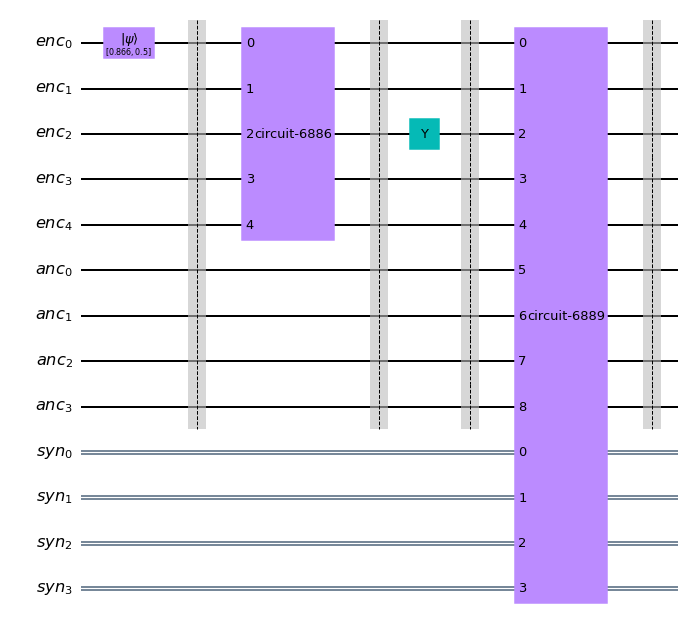

In [32]:
qc.append(qc_correct, qargs=[q_enc[0], q_enc[1], q_enc[2], q_enc[3], q_enc[4], q_anc[0], q_anc[1], q_anc[2], q_anc[3]],
          cargs=[c_syn[0], c_syn[1], c_syn[2], c_syn[3]])
qc.barrier()

qc.draw("mpl")

## Decoding circuit

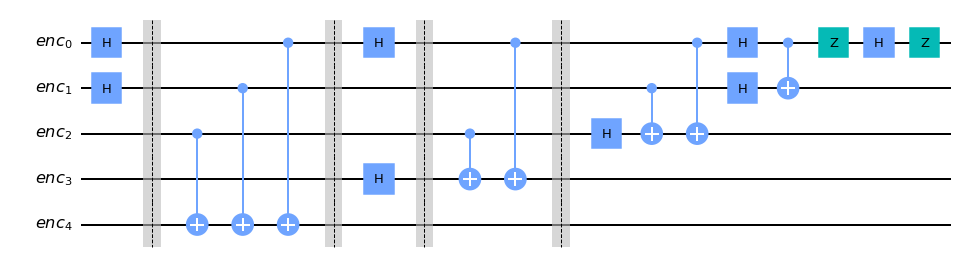

In [33]:
q_enc_t = QuantumRegister(5, "enc")
qc_decoding = QuantumCircuit(q_enc_t)

qc_decoding.h(q_enc_t[1])
qc_decoding.h(q_enc_t[0])

qc_decoding.barrier()

qc_decoding.cx(q_enc_t[2], q_enc_t[4])
qc_decoding.cx(q_enc_t[1], q_enc_t[4])
qc_decoding.cx(q_enc_t[0], q_enc_t[4])

qc_decoding.barrier()

qc_decoding.h(q_enc_t[3])
qc_decoding.h(q_enc_t[0])

qc_decoding.barrier()

qc_decoding.cx(q_enc_t[2], q_enc_t[3])
qc_decoding.cx(q_enc_t[0], q_enc_t[3])

qc_decoding.barrier()

qc_decoding.h(q_enc_t[2])

qc_decoding.cx(q_enc_t[1], q_enc_t[2])
qc_decoding.cx(q_enc_t[0], q_enc_t[2])

qc_decoding.h(q_enc_t[1])
qc_decoding.h(q_enc_t[0])

qc_decoding.cx(q_enc_t[0], q_enc_t[1])


qc_decoding.z(q_enc_t[0])
qc_decoding.h(q_enc_t[0])
qc_decoding.z(q_enc_t[0])


qc_decoding.draw("mpl")

## Adding the decoding cirucit to the main circuit

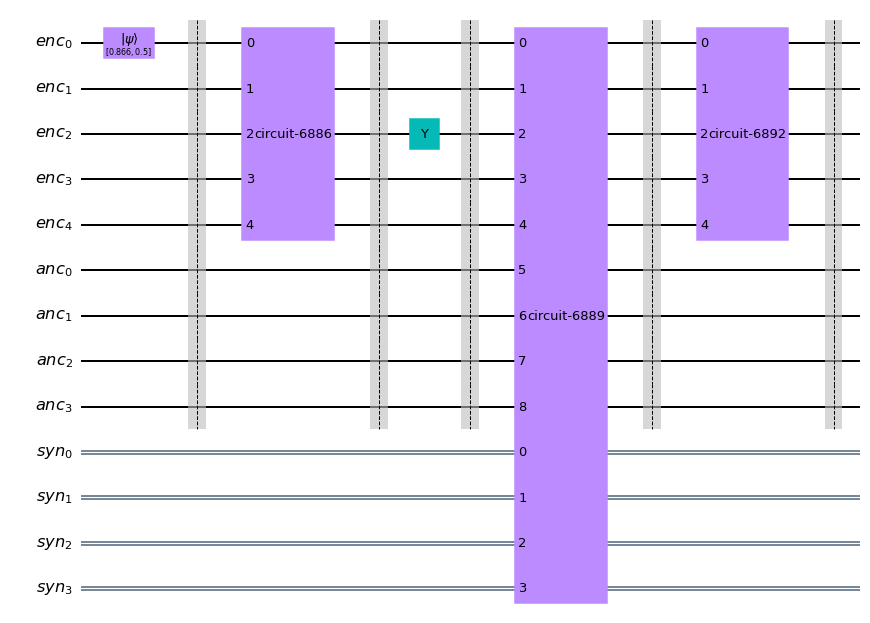

In [34]:
qc.append(qc_decoding, [q_enc[0], q_enc[1], q_enc[2], q_enc[3], q_enc[4]])
qc.barrier()
qc.draw("mpl")

## Executing the circuit

We execute the cirucit showing $|\psi\rangle$ at the end, and the error syndrome measured

In [57]:
backend = Aer.get_backend('statevector_simulator')
outputstate = execute(qc, backend).result().get_statevector(decimals=3)
alpha = outputstate[0]
beta = outputstate[1]

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1)
syndrome = job.result().get_counts(qc)

print(f"Input state: {round(alpha_in, 3)}|0> + {round(beta_in, 3)}|1>")
print(f"\nSyndrome: {list(syndrome.keys())[0][::-1]}")
print(f"\nDecoded state: {alpha}|0> + {beta}|1>")

Input state: 0.866|0> + 0.5|1>

Syndrome: 0000

Decoded state: (0.866-0j)|0> + (0.5-0j)|1>


## Defining a test function

We define a function to make the cirucit easier to test of different errors and different input qubits. The function takes as input arguments:
- `input_qubit`: which is a list of two elements, where the first is the amplitude of $|0\rangle$ and the second is the amplitude of $|1\rangle$
- `X_error_mask`: which is a tuple of five elements, where if the element in position $i$ is 1 it means that there will be an $X$ error on the $i$-th qubit after the encoding, if it is 0 there will be no error on that qubit
- `Y_error_mask`: which is a tuple of five elements, where if the element in position $i$ is 1 it means that there will be an $Y$ error on the $i$-th qubit after the encoding, if it is 0 there will be no error on that qubit
- `Z_error_mask`: which is a tuple of five elements, where if the element in position $i$ is 1 it means that there will be an $Z$ error on the $i$-th qubit after the encoding, if it is 0 there will be no error on that qubit

In [64]:
def circuit(input_qubit, X_error_mask, Y_error_mask, Z_error_mask):
    
    # initialization
    
    q_enc = QuantumRegister(5, "enc")
    q_anc = QuantumRegister(4, "anc")
    c_syn = ClassicalRegister(4, "syn")

    qc = QuantumCircuit(q_enc, q_anc, c_syn)
    qc.initialize(input_qubit, [q_enc[0]])
    qc.barrier()
    
    # encoding

    q_enc_t = QuantumRegister(5, "enc")
    qc_encoding = QuantumCircuit(q_enc_t)

    qc_encoding.z(q_enc_t[0])
    qc_encoding.h(q_enc_t[0])
    qc_encoding.z(q_enc_t[0])

    qc_encoding.cx(q_enc_t[0], q_enc_t[1])

    qc_encoding.h(q_enc_t[0])
    qc_encoding.h(q_enc_t[1])

    qc_encoding.cx(q_enc_t[0], q_enc_t[2])
    qc_encoding.cx(q_enc_t[1], q_enc_t[2])

    qc_encoding.h(q_enc_t[2])
    qc_encoding.barrier()

    qc_encoding.cx(q_enc_t[0], q_enc_t[3])
    qc_encoding.cx(q_enc_t[2], q_enc_t[3])

    qc_encoding.barrier()

    qc_encoding.h(q_enc_t[0])
    qc_encoding.h(q_enc_t[3])

    qc_encoding.cx(q_enc_t[0], q_enc_t[4])
    qc_encoding.cx(q_enc_t[1], q_enc_t[4])
    qc_encoding.cx(q_enc_t[2], q_enc_t[4])

    qc_encoding.barrier()

    qc_encoding.h(q_enc_t[0])
    qc_encoding.h(q_enc_t[1])
    
    qc.append(qc_encoding, [q_enc[0], q_enc[1], q_enc[2], q_enc[3], q_enc[4]])
    qc.barrier()
    
    # error
    
    for i in range(5):
        if X_error_mask[i] == 1:
            qc.x(q_enc[i])
        if Y_error_mask[i] == 1:
            qc.y(q_enc[i])
        if Z_error_mask[i] == 1:
            qc.z(q_enc[i])
    
    
    # detection + correction
    
    q_enc_t = QuantumRegister(5, "enc")
    q_anc_t = QuantumRegister(4, "anc")
    c_syn_t = ClassicalRegister(4, "syn")

    qc_correct = QuantumCircuit(q_enc_t, q_anc_t, c_syn_t)
    qc_correct.h(q_anc_t[0])
    qc_correct.h(q_anc_t[1])
    qc_correct.h(q_anc_t[2])
    qc_correct.h(q_anc_t[3])
    qc_correct.barrier()

    qc_correct.cz(q_anc_t[0], q_enc_t[1])
    qc_correct.cx(q_anc_t[0], q_enc_t[2])
    qc_correct.cx(q_anc_t[0], q_enc_t[3])
    qc_correct.cz(q_anc_t[0], q_enc_t[4])
    qc_correct.barrier()


    qc_correct.cz(q_anc_t[1], q_enc_t[0])
    qc_correct.cz(q_anc_t[1], q_enc_t[2])
    qc_correct.cx(q_anc_t[1], q_enc_t[3])
    qc_correct.cx(q_anc_t[1], q_enc_t[4])
    qc_correct.barrier()


    qc_correct.cx(q_anc_t[2], q_enc_t[0])
    qc_correct.cz(q_anc_t[2], q_enc_t[1])
    qc_correct.cz(q_anc_t[2], q_enc_t[3])
    qc_correct.cx(q_anc_t[2], q_enc_t[4])
    qc_correct.barrier()


    qc_correct.cx(q_anc_t[3], q_enc_t[0])
    qc_correct.cx(q_anc_t[3], q_enc_t[1])
    qc_correct.cz(q_anc_t[3], q_enc_t[2])
    qc_correct.cz(q_anc_t[3], q_enc_t[4])
    qc_correct.barrier()

    qc_correct.h(q_anc_t[0])
    qc_correct.h(q_anc_t[1])
    qc_correct.h(q_anc_t[2])
    qc_correct.h(q_anc_t[3])

    qc_correct.measure(q_anc_t[0], c_syn_t[0])
    qc_correct.measure(q_anc_t[1], c_syn_t[1])
    qc_correct.measure(q_anc_t[2], c_syn_t[2])
    qc_correct.measure(q_anc_t[3], c_syn_t[3])

    qc_correct.barrier()

    qc_correct.x(q_enc_t[0]).c_if(c_syn_t, 2)
    qc_correct.x(q_enc_t[1]).c_if(c_syn_t, 5)
    qc_correct.x(q_enc_t[2]).c_if(c_syn_t, 10)
    qc_correct.x(q_enc_t[3]).c_if(c_syn_t, 4)
    qc_correct.x(q_enc_t[4]).c_if(c_syn_t, 9)

    
    qc_correct.y(q_enc_t[0]).c_if(c_syn_t, 14)
    qc_correct.y(q_enc_t[1]).c_if(c_syn_t, 13)
    qc_correct.y(q_enc_t[2]).c_if(c_syn_t, 11)
    qc_correct.y(q_enc_t[3]).c_if(c_syn_t, 7)
    qc_correct.y(q_enc_t[4]).c_if(c_syn_t, 15)
    
    qc_correct.z(q_enc_t[0]).c_if(c_syn_t, 12)
    qc_correct.z(q_enc_t[1]).c_if(c_syn_t, 8)
    qc_correct.z(q_enc_t[2]).c_if(c_syn_t, 1)
    qc_correct.z(q_enc_t[3]).c_if(c_syn_t, 3)
    qc_correct.z(q_enc_t[4]).c_if(c_syn_t, 6)
    
    
    qc_correct.x(q_anc_t[0]).c_if(c_syn_t[0], 1)
    qc_correct.x(q_anc_t[1]).c_if(c_syn_t[1], 1)
    qc_correct.x(q_anc_t[2]).c_if(c_syn_t[2], 1)
    qc_correct.x(q_anc_t[3]).c_if(c_syn_t[3], 1)
    
    qc.append(qc_correct, qargs=[q_enc[0], q_enc[1], q_enc[2], q_enc[3], q_enc[4], q_anc[0], q_anc[1], q_anc[2], q_anc[3]],
              cargs=[c_syn[0], c_syn[1], c_syn[2], c_syn[3]])
    qc.barrier()
    
    
    # decoding

    q_enc_t = QuantumRegister(5, "enc")
    qc_decoding = QuantumCircuit(q_enc_t)

    qc_decoding.h(q_enc_t[1])
    qc_decoding.h(q_enc_t[0])

    qc_decoding.barrier()

    qc_decoding.cx(q_enc_t[2], q_enc_t[4])
    qc_decoding.cx(q_enc_t[1], q_enc_t[4])
    qc_decoding.cx(q_enc_t[0], q_enc_t[4])

    qc_decoding.barrier()

    qc_decoding.h(q_enc_t[3])
    qc_decoding.h(q_enc_t[0])

    qc_decoding.barrier()

    qc_decoding.cx(q_enc_t[2], q_enc_t[3])
    qc_decoding.cx(q_enc_t[0], q_enc_t[3])

    qc_decoding.barrier()

    qc_decoding.h(q_enc_t[2])

    qc_decoding.cx(q_enc_t[1], q_enc_t[2])
    qc_decoding.cx(q_enc_t[0], q_enc_t[2])

    qc_decoding.h(q_enc_t[1])
    qc_decoding.h(q_enc_t[0])

    qc_decoding.cx(q_enc_t[0], q_enc_t[1])


    qc_decoding.z(q_enc_t[0])
    qc_decoding.h(q_enc_t[0])
    qc_decoding.z(q_enc_t[0])
    
    
    qc.append(qc_decoding, [q_enc[0], q_enc[1], q_enc[2], q_enc[3], q_enc[4]])
    qc.barrier()
    
    # get state vector    
    backend = Aer.get_backend('statevector_simulator')
    outputstate = execute(qc, backend).result().get_statevector(decimals=3)
    alpha = outputstate[0]
    beta = outputstate[1]

    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1)
    syndrome = job.result().get_counts(qc)
    
    return alpha, beta, syndrome, qc

You can play with the below code cell, by varying the values of the input parameters of the function

Input state: 0.866|0> + 0.5|1>

Syndrome: 0101

Decoded state: (0.866-0j)|0> + (0.5-0j)|1>


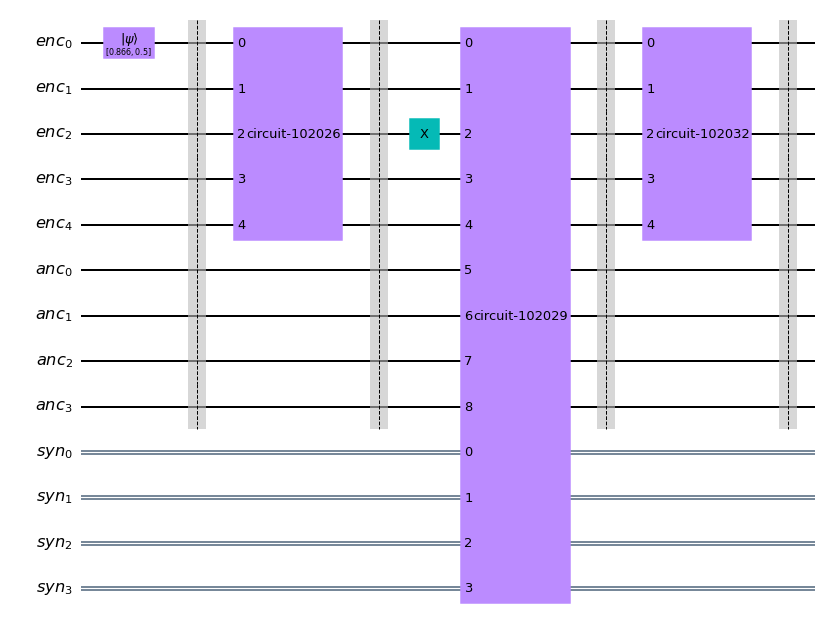

In [67]:
alpha_in = sqrt(3/4)
beta_in = sqrt(1/4)
input_qubit = [alpha_in, beta_in]
X_error_mask = (0,0,1,0,0)
Y_error_mask = (0,0,0,0,0)
Z_error_mask = (0,0,0,0,0)

alpha, beta, syndrome, qc = circuit(input_qubit, X_error_mask, Y_error_mask, Y_error_mask)
print(f"Input state: {round(alpha_in, 3)}|0> + {round(beta_in, 3)}|1>")
print(f"\nSyndrome: {list(syndrome.keys())[0][::-1]}")
print(f"\nDecoded state: {alpha}|0> + {beta}|1>")
qc.draw("mpl")

## Showing all the syndromes

In the following code cell we test the cirucit on every possible error and we show the syndromes:

In [40]:
alpha_in = sqrt(3/4)
beta_in = sqrt(1/4)
input_state = [alpha_in, beta_in]

print(f"Input state: {round(alpha_in, 3)}|0> + {round(beta_in, 3)}|1>\n")

i = 0
for mask in [(1,0,0,0,0),(0,1,0,0,0),(0,0,1,0,0),(0,0,0,1,0),(0,0,0,0,1)]:
    i+=1
    alpha, beta, syndrome, qc = circuit(input_state, mask, (0,0,0,0,0), (0,0,0,0,0))
    print("X" + str(i) + ":" + list(syndrome.keys())[0][::-1])
    print(f"Decoded state:\n{alpha}|0> + {beta}|1>\n")

i = 0
for mask in [(1,0,0,0,0),(0,1,0,0,0),(0,0,1,0,0),(0,0,0,1,0),(0,0,0,0,1)]:
    i+=1
    alpha, beta, syndrome, qc = circuit(input_state, (0,0,0,0,0), mask, (0,0,0,0,0))
    print("Y" + str(i) + ":" + list(syndrome.keys())[0][::-1])
    print(f"Decoded state:\n{alpha}|0> + {beta}|1>\n")
    
i = 0
for mask in [(1,0,0,0,0),(0,1,0,0,0),(0,0,1,0,0),(0,0,0,1,0),(0,0,0,0,1)]:
    i+=1
    alpha, beta, syndrome, qc = circuit(input_state, (0,0,0,0,0), (0,0,0,0,0), mask)
    print("Z" + str(i) + ":" + list(syndrome.keys())[0][::-1])
    print(f"Decoded state:\n{alpha}|0> + {beta}|1>\n")

Input state: 0.866|0> + 0.5|1>

X1:0100
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

X2:1010
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

X3:0101
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

X4:0010
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

X5:1001
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Y1:0111
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Y2:1011
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Y3:1101
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Y4:1110
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Y5:1111
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Z1:0011
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Z2:0001
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Z3:1000
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Z4:1100
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

Z5:0110
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>

